## Problem Statement

Indonesian President has a plan to move the government office (currently in Jakarta) of Indonesia to another place outside Jakarta. This plan is taken because jakarta population density is to high which raise some problem such as lack of clean water, traffic jam, air polution, etc. A proper place should be found to make sure that the government officers have the same productivity as in Jakarta. The productivity will be influenced by public facilities, entertainment(food court, cafe, karaoke, and tourism place), health infrastructure, and sports facilities. The president needs to classify some cities in Indonesia to make a best choice. This project will try to help the president to cluster some cities that are similar to Jakarta, as the chosen place in a map view. there are several candidate cities that have been proposed to the president.

## Data Processing Strategy
This project will utilize some data from wikipedia to cover some information such as city population, city area, and city position. It will be combined with some data from foursquare API to get the raw data about venues in Indonesia. At the end K-mean clustering will be used to clustering the data to find the likeliness of the city.


In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import requests
import io
import json as j
from pandas.io.json import json_normalize

#### Scraping data from wiki about city list in Indonesia

In [3]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_Indonesian_cities_by_population")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df_cities = pd.read_html(str(table))
df_cities = df_cities[0]  
print(df_cities.head(), '\n shape: ',df_cities.shape)

   Rank        Cities                           Province  2010 censusBPS[4]  \
0     1  East Jakarta  Special Capital Region of Jakarta            2693896   
1     2      Surabaya                          East Java            2765487   
2     3         Medan                      North Sumatra            2097610   
3     4        Bekasi                          West Java            2334871   
4     5       Bandung                          West Java            2394873   

   2015 dataKemendagri[5]  
0                 2852887  
1                 2805906  
2                 2465469  
3                 2381053  
4                 2339463   
 shape:  (98, 5)


There is a problem where Jakarta is divided into four area sectors in the wikipedia list. I need to grouping the sectors and rename it as jakarta. 

Procedure:
    1. Divide the data into two sets of data, without and with jakarta
    2. Do cum operation while grouping the jakarta data and replace the name as jakarta
    3. Reunite the data by merging them

In [5]:
ctlswtJakarta=df_cities[df_cities['Cities'].str.contains('Jakarta')==False]
ctlswtJakarta=ctlswtJakarta.drop('Rank',axis=1)

ctlsJakarta=df_cities[df_cities['Cities'].str.contains('Jakarta')]
ctlsJakarta=ctlsJakarta.drop('Rank',axis=1)
ctlsJakarta.loc[ctlsJakarta['Cities'].str.contains('Jakarta'), 'Cities'] = 'Jakarta'
ctlsJakarta=ctlsJakarta.groupby(['Cities','Province'], as_index=False).sum()

ctls=ctlswtJakarta.append(ctlsJakarta,sort=False)
print(ctls.head(10), '\n shape: ',ctls.shape)

             Cities        Province  2010 censusBPS[4]  2015 dataKemendagri[5]
1          Surabaya       East Java            2765487                 2805906
2             Medan   North Sumatra            2097610                 2465469
3            Bekasi       West Java            2334871                 2381053
4           Bandung       West Java            2394873                 2339463
7          Makassar  South Sulawesi            1338663                 1651146
9             Depok       West Java            1738570                 1631951
10         Semarang    Central Java            1555984                 1621384
11        Tangerang          Banten            1798601                 1566190
12        Palembang   South Sumatra            1455284                 1548064
13  South Tangerang          Banten            1290322                 1219245 
 shape:  (94, 4)


#### Get data from foursquare API about venues and categories
I have create a function to extract the data properly (I do research previously for getting the best procedure)

In [6]:
ID = 'OFQTPGID1QLNZE2NQQ0KAU0Z243ZFHN4LQD4UR4BXHLKB3ZA' # your Foursquare ID
SECRET = 'BSQIBAZPWIE2NKQJT2YK2VQB1Y042HMIXF13EQS3VR0UZY21' # your Foursquare Secret
V = '20190719' # Foursquare API version
# city='Surabaya'
radius=100000
LIMIT=50

In [7]:
def getVenues(df,ID,SECRET,V,radius,LIMIT):
    
    for place in ctls['Cities']:
        print(place)
        near=place
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&near={}&intent=checkin&radius={}&LIMIT={}'.format(
            ID, 
            SECRET, 
            V, 
            near,
            radius,
            LIMIT)
        try:
            ls = requests.get(url).json()

            dt = j.loads(j.dumps(ls))
            venls=json_normalize(data=dt['response']['venues'])
            venls=venls.drop(['hasPerk','location.labeledLatLngs','referralId','location.cc','categories'],axis=1)

            catls=json_normalize(data=dt['response']['venues'],record_path=['categories'],meta=['id'],record_prefix='_')
            catls=catls.drop(['_icon','_id'],axis=1)

            vencatls=pd.merge(venls,catls,on='id',how='inner')
            vencatls=vencatls.rename(columns={'id':'id','location.address':'address','location.city':'city','location.country':'country','location.crossStreet':'cross street','location.formattedAddres':'formatted address','location.lat':'lat','location.lng':'long','location.postalCode':'postal code','location.state':'state','name':'name','_name':'cat name','_pluralName':'cat plural name','_primary':'cat primary','_shortName':'cat shortname'})
            print('add '+place+' to list!')
            print('Shape of '+place+' = ')
            print(vencatls.shape)
            df=df.append(vencatls, ignore_index=True,sort=False)
           
        except:
            pass

    return(df)


In [8]:
# Call the function
venuesList=pd.DataFrame()
venuesList=getVenues(df=venuesList,ID=ID,SECRET=SECRET,V=V,radius=radius,LIMIT=LIMIT)

Surabaya
add Surabaya to list!
Shape of Surabaya = 
(15, 16)
Medan
add Medan to list!
Shape of Medan = 
(24, 16)
Bekasi
add Bekasi to list!
Shape of Bekasi = 
(16, 15)
Bandung
add Bandung to list!
Shape of Bandung = 
(28, 15)
Makassar
add Makassar to list!
Shape of Makassar = 
(14, 15)
Depok
add Depok to list!
Shape of Depok = 
(21, 15)
Semarang
add Semarang to list!
Shape of Semarang = 
(17, 15)
Tangerang
add Tangerang to list!
Shape of Tangerang = 
(22, 15)
Palembang
add Palembang to list!
Shape of Palembang = 
(7, 15)
South Tangerang
add South Tangerang to list!
Shape of South Tangerang = 
(15, 15)
Bandar Lampung
add Bandar Lampung to list!
Shape of Bandar Lampung = 
(27, 16)
Batam
add Batam to list!
Shape of Batam = 
(8, 15)
Bogor
add Bogor to list!
Shape of Bogor = 
(17, 15)
Padang
add Padang to list!
Shape of Padang = 
(25, 15)
Pekanbaru
add Pekanbaru to list!
Shape of Pekanbaru = 
(17, 16)
Malang
add Malang to list!
Shape of Malang = 
(21, 16)
Samarinda
add Samarinda to list!
Sh

In [9]:
#remove some unused column
venuesList=venuesList.drop(['location.neighborhood','venuePage.id','cat primary','location.formattedAddress'],axis=1)

In [10]:
print(venuesList.head(),'\n',venuesList.shape)

                         id                address      city    country  \
0  5062d578e4b0e915a14444df             Jl.Ngaglik       NaN  Indonesia   
1  4bfb95e6ab180f470bfeb3ce                    NaN  Surabaya  Indonesia   
2  4bb2fa1ca32876b0a13b01fe  Jl. Tambaksari No. 10  Surabaya  Indonesia   
3  4c21a587aa8e9c74e047f4d4      Jl. Jagalan No.18  Surabaya  Indonesia   
4  502a162ee4b0b811eace9d76             Jl.ngaglik       NaN  Indonesia   

       cross street       lat        long postal code       state  \
0               NaN -7.249111  112.751399         NaN         NaN   
1               NaN -7.249150  112.753293         NaN  Jawa Timur   
2               NaN -7.249300  112.755606       60136  Jawa Timur   
3  Jl. Undaan Kulon -7.248188  112.746144       60161  Jawa Timur   
4               NaN -7.248956  112.751030         NaN         NaN   

                         name              cat name        cat plural name  \
0                   Jamu Iboe     Convenience Store     

#### Visualize some data to see the pattern 
For the first visualization, I will see the total of venues in every city, and list some venues that has total greater or equal to total venues in Jakarta as the baseline to find the best city

In [11]:
#check the city data from API, is the data clean enough to be proccessed
venuesList['city'].unique()

array([nan, 'Surabaya', 'Medan', 'Medan Polonia', 'Bekasi', 'Pekanbaru',
       'Bandung', 'Kecamatan Bandung Wetan', 'Tasikmalaya', 'Makassar',
       'Depok', 'Pancoran Mas', 'Pancoran MAS',
       'Depok, Jakarta Capital Region', 'Semarang', 'Tangerang',
       'Palembang', 'Sukarami', 'Bintaro', 'South Tangerang',
       'Tangerang Selatan', 'Ciputat', 'Bandar Lampung', 'Lampung',
       'Teluk Betung', 'Batam', 'New York', 'Bogor', 'Purwakarta',
       'Padang', 'Osaka', 'Malang', 'Samarinda', 'Balikpapan',
       'Pontianak', 'Kecamatan Pontianak Kota', 'Banjarmasin',
       'Indonesia', 'Denpasar', 'Bali', 'Serang', 'Surakarta', 'BATAM',
       'Cimahi', 'Central Cimahi', 'Kecamatan Cimahi Tengah', 'Manado',
       'Kupang - NTT', 'Kupang', 'Jayapura', 'Mataram', 'West Lombok',
       'Ampenan', 'Cakranegara', 'Nusa Tenggara Barat', 'Yogyakarta',
       'YOGYA', 'Cilegon', 'Ambon', 'Bengkulu', 'Sentra oleh2',
       'Ratu Samban', 'Palu', 'Kecamatan Palu Timur', 'Kendari',
     

I found that the name is not standardize, so I will clean the data by extracting the data from api that have the same city list that has been extracted prviously from wikipedia

In [16]:
com_place=pd.merge(ctls['Cities'],venuesList,how='inner',left_on=['Cities'],right_on=['city'])
print(com_place.head(),'\n count venues raw: ',venuesList.shape,' count clean city data: ',com_place.shape)

     Cities                        id                address      city  \
0  Surabaya  4bfb95e6ab180f470bfeb3ce                    NaN  Surabaya   
1  Surabaya  4bb2fa1ca32876b0a13b01fe  Jl. Tambaksari No. 10  Surabaya   
2  Surabaya  4c21a587aa8e9c74e047f4d4      Jl. Jagalan No.18  Surabaya   
3  Surabaya  4c42e6dea5c5ef3bd69ab06f                ngaglik  Surabaya   
4  Surabaya  574a4c3838fa943555f6782c            Jl. Ngaglik  Surabaya   

     country      cross street       lat        long postal code       state  \
0  Indonesia               NaN -7.249150  112.753293         NaN  Jawa Timur   
1  Indonesia               NaN -7.249300  112.755606       60136  Jawa Timur   
2  Indonesia  Jl. Undaan Kulon -7.248188  112.746144       60161  Jawa Timur   
3  Indonesia           ngaglik -7.248619  112.750772         NaN  Jawa Timur   
4  Indonesia               NaN -7.249005  112.750540         NaN  Jawa Timur   

                         name                   cat name  \
0      Rel ker

In [17]:
venuesList_clean=com_place.drop('city',axis=1)
venuesList_clean.groupby(['Cities']).size()

Cities
Ambon              21
Balikpapan         12
Banda Aceh         19
Bandar Lampung     22
Bandung            22
Banjarbaru          6
Banjarmasin        11
Batam               3
Batu                6
Baubau             12
Bekasi              9
Bengkulu           14
Bima               11
Binjai             25
Bitung              9
Blitar             27
Bogor              13
Bontang            14
Bukittinggi         7
Cilegon            14
Cimahi             13
Cirebon            13
Denpasar           12
Depok              11
Dumai              19
Gorontalo          10
Gunungsitoli       12
Jakarta            11
Jambi               1
Jayapura            9
                   ..
Pekanbaru          17
Pematangsiantar     5
Pontianak          15
Prabumulih          5
Probolinggo        20
Sabang             14
Salatiga           13
Samarinda          11
Sawahlunto          5
Semarang           16
Serang             10
Sibolga            17
Singkawang         11
Solok              16
Sor

In [18]:
import numpy as np
import matplotlib.pyplot as plt
# we found jakarta has 12 listed venue, so it will be used as the baseline, because Jakarta is the capital city of indonesia
vengret12=pd.DataFrame()
for place in venuesList_clean['Cities'].unique():
    if venuesList_clean.loc[venuesList_clean['Cities']==place].shape[0]>12:
        vengret12=vengret12.append(venuesList_clean.loc[venuesList_clean['Cities']==place])
        print(place,' is processed!')
    else:
        print('skip ',place)
print(vengret12.head())

skip  Surabaya
Medan  is processed!
skip  Bekasi
Bandung  is processed!
skip  Makassar
skip  Depok
Semarang  is processed!
Tangerang  is processed!
skip  Palembang
skip  South Tangerang
Bandar Lampung  is processed!
skip  Batam
Bogor  is processed!
skip  Padang
Pekanbaru  is processed!
Malang  is processed!
skip  Samarinda
Tasikmalaya  is processed!
Pontianak  is processed!
skip  Banjarmasin
skip  Denpasar
skip  Serang
skip  Jambi
skip  Balikpapan
skip  Surakarta
Cimahi  is processed!
Manado  is processed!
Kupang  is processed!
skip  Jayapura
skip  Mataram
Yogyakarta  is processed!
Cilegon  is processed!
Ambon  is processed!
Bengkulu  is processed!
skip  Palu
Kendari  is processed!
Sukabumi  is processed!
Cirebon  is processed!
Pekalongan  is processed!
Kediri  is processed!
skip  Pematangsiantar
Tegal  is processed!
skip  Sorong
Binjai  is processed!
Dumai  is processed!
skip  Palangka Raya
Banda Aceh  is processed!
skip  Singkawang
Probolinggo  is processed!
skip  Bitung
skip  Banjar

In [19]:
## Visualize the cleaner data
x1 = venuesList_clean['Cities'].unique()
x2 = vengret12['Cities'].unique()
y1 = venuesList_clean.groupby(['Cities']).size()
y2 = vengret12.groupby(['Cities']).size()

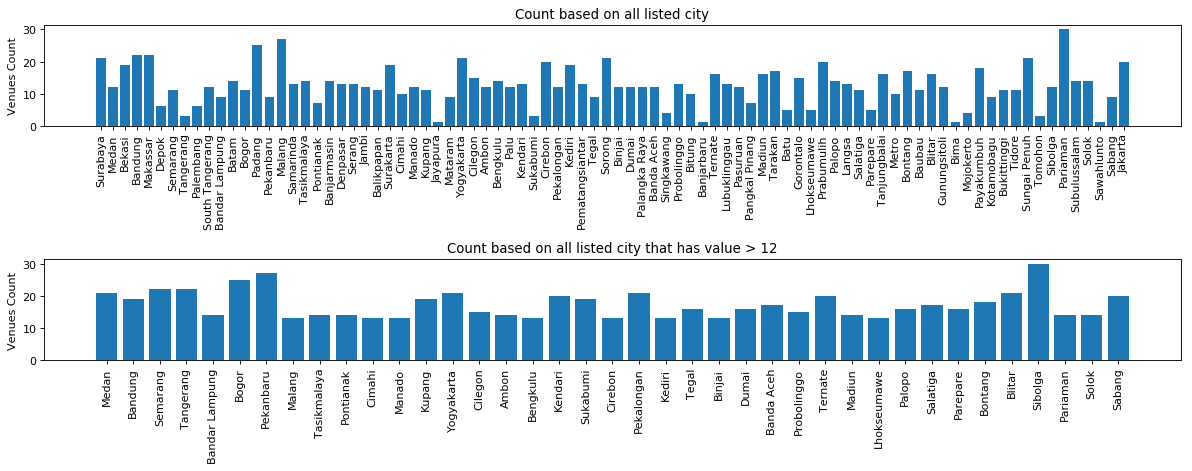

In [21]:
from matplotlib.pyplot import figure 
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 1, 1)
plt.bar(x1, y1, width=0.8)
plt.title('Count based on all listed city')
plt.xticks(rotation=90)
plt.ylabel('Venues Count')

plt.subplot(2, 1, 2)
plt.bar(x2, y2, width=0.8)
plt.title('Count based on all listed city that has value > 12')
plt.xticks(rotation=90)
plt.ylabel('Venues Count')

plt.tight_layout()
plt.show()

In [23]:
## Visualize all potential city that have 12 or more than 12 venues in a map
# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude = -6.121435
longitude = 106.774124
map_potct = folium.Map(location=[latitude, longitude], zoom_start=4)


# add markers to map
for lat, lng, name, city in zip(venuesList_clean['lat'], venuesList_clean['long'], venuesList_clean['name'], venuesList_clean['Cities']):
    label = '{}, {}'.format(name, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_potct)  
# uncomment to see the map    
map_potct

Venues count is not the only consideration to decide the potential city. In this use case assumption, the city should have food court, stores, medical infrstructure, financial services, office building, entertainment services, and sport facilities.

In [24]:
#Get some keywords to extract venues based on the defined category/consideration
food1=venuesList_clean[venuesList_clean['cat name'].str.contains('Rest')]
food2=venuesList_clean[venuesList_clean['cat name'].str.contains('Food')]
food3=venuesList_clean[venuesList_clean['cat name'].str.contains('Breakfast')]
food=food1.append([food2,food3])
food['cat group']='Food'

store1=venuesList_clean[venuesList_clean['cat name'].str.contains('tore')]
store2=venuesList_clean[venuesList_clean['cat name'].str.contains('hop')]
store3=venuesList_clean[venuesList_clean['cat name'].str.contains('arke')]
store=store1.append([store2,store3])
store['cat group']='store'

office1=venuesList_clean[venuesList_clean['cat name'].str.contains('Office')]
office2=venuesList_clean[venuesList_clean['cat name'].str.contains('Build')]
office=office1.append([office2])
office['cat group']='office'

trans1=venuesList_clean[venuesList_clean['cat name'].str.contains('Station')]
trans2=venuesList_clean[venuesList_clean['cat name'].str.contains('Travel')]
trans=trans1.append([trans2])
trans['cat group']='transportation'


entertain1=venuesList_clean[venuesList_clean['cat name'].str.contains('Karaoke')]
entertain2=venuesList_clean[venuesList_clean['cat name'].str.contains('Garden')]
entertain=entertain1.append([entertain2])
entertain['cat group']='entertainment'

finance=venuesList_clean[venuesList_clean['cat name'].str.contains('Bank')]
finance['cat group']='finance'


health1=venuesList_clean[venuesList_clean['cat name'].str.contains('Medi')]
health2=venuesList_clean[venuesList_clean['cat name'].str.contains('Hosp')]
health3=venuesList_clean[venuesList_clean['cat name'].str.contains('harm')]
health=health1.append([health2,health3])
health['cat group']='health'

sport1=venuesList_clean[venuesList_clean['cat name'].str.contains('Sport')]
sport2=venuesList_clean[venuesList_clean['cat name'].str.contains('Hall')]
sport3=venuesList_clean[venuesList_clean['cat name'].str.contains('Volleyball')]
sport4=venuesList_clean[venuesList_clean['cat name'].str.contains('Tennis')]
sport5=venuesList_clean[venuesList_clean['cat name'].str.contains('Soccer')]
sport6=venuesList_clean[venuesList_clean['cat name'].str.contains('Gym')]
sport=sport1.append([sport2,sport3,sport4,sport5,sport6])
sport['cat group']='sport'
print('food:',food.shape,'\n','store:',store.shape,'\n','office:',office.shape,'\n'
      ,'trans:',trans.shape,'\n','entertainment:',entertain.shape,'\n','finance:',finance.shape
      ,'\n','health:',health.shape,'\n','sport:',sport.shape)

food: (227, 14) 
 store: (157, 14) 
 office: (153, 14) 
 trans: (24, 14) 
 entertainment: (8, 14) 
 finance: (36, 14) 
 health: (39, 14) 
 sport: (26, 14)


C:\Users\CaesarIrawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
mand_ven=food.append([store,office,trans,entertain,finance,health])
print(mand_ven.head(),'\n',mand_ven.shape,'\n',mand_ven.info(),'\n',mand_ven['Cities'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644 entries, 3 to 967
Data columns (total 14 columns):
Cities             644 non-null object
id                 644 non-null object
address            606 non-null object
country            644 non-null object
cross street       197 non-null object
lat                644 non-null float64
long               644 non-null float64
postal code        133 non-null object
state              640 non-null object
name               644 non-null object
cat name           644 non-null object
cat plural name    644 non-null object
cat shortname      644 non-null object
cat group          644 non-null object
dtypes: float64(2), object(12)
memory usage: 75.5+ KB
      Cities                        id                               address  \
3   Surabaya  4c42e6dea5c5ef3bd69ab06f                               ngaglik   
13     Medan  5ccd9f76342adf002bf66eed  Jl. S Parman No. 3 Depan Athena Baby   
15     Medan  4bd191929854d13afeb7f94d               

In [26]:
# Visualize the potential city that has proper infrastructure and services in map view
latitude = -6.121435
longitude = 106.774124
map_potct = folium.Map(location=[latitude, longitude], zoom_start=4)


# add markers to map
for lat, lng, name, city in zip(mand_ven['lat'], mand_ven['long'], mand_ven['name'], mand_ven['Cities']):
    label = '{}, {}'.format(name, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_potct)  
# uncomment to see the map    
map_potct

### Prepare Data For Training and Clustering the data

In [28]:
# one hot encoding
ven_onehot = pd.get_dummies(mand_ven[['cat group']], prefix="", prefix_sep="")

# add id and city column back to dataframe
ven_onehot['Cities'] = mand_ven['Cities']
ven_onehot=ven_onehot.groupby('Cities', as_index=False).sum().reset_index()

print(ven_onehot.head(),'\n',ven_onehot.shape) 

   index          Cities  Food  entertainment  finance  health  office  store  \
0      0           Ambon     4              0        1       2       3      2   
1      1      Balikpapan     0              0        0       0       4      0   
2      2      Banda Aceh     7              0        1       1       1      6   
3      3  Bandar Lampung     4              0        0       0       7      4   
4      4         Bandung     8              0        0       0       1      4   

   transportation  
0               1  
1               1  
2               0  
3               0  
4               1   
 (83, 9)


In [29]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 10

ven_clustering = ven_onehot.drop('Cities', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ven_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 9, 9, 9, 9, 9])

In [30]:
ven_clustering_sorted = pd.DataFrame()
ven_clustering_sorted['Cities'] = ven_onehot['Cities']
# add clustering labels
ven_clustering_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ven_clustering_sorted.head(10)

,Cluster Labels,Cities
0,2,Ambon
1,2,Balikpapan
2,2,Banda Aceh
3,2,Bandar Lampung
4,2,Bandung
5,9,Banjarbaru
6,9,Banjarmasin
7,9,Batu
8,9,Baubau
9,9,Bekasi


In [31]:
# extract data from wikiedia to get the location of city that is potential based on the label from clustering procedure
citieslist=pd.read_csv('/worldcities.csv')
indolist=citieslist[citieslist['country']=='Indonesia']

#get lat long for labeled cities
venformap=pd.merge(ven_clustering_sorted,indolist, how='inner', left_on='Cities', right_on='city_ascii')
venformap=venformap.drop(['Cities','city_ascii','country','iso2','iso3','admin_name','capital','id'],1)
venformap.head()

,Cluster Labels,city,lat,lng,population
0,2,Ambon,-3.7167,128.20,355596.0
1,2,Balikpapan,-1.2500,116.83,445905.0
2,2,Banda Aceh,5.5500,95.32,513698.0
3,2,Bandar Lampung,-5.4300,105.27,865000.0
4,2,Bandung,-6.9500,107.57,2394000.0


In [32]:
# Visualize the result of clustering to find similar city like Jakarta
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

latitude = -6.121435
longitude = 106.774124
map_all_cls = folium.Map(location=[latitude, longitude], zoom_start=4)


# add markers to map
for lat, lng, city, cluster in zip(venformap['lat'], venformap['lng'], venformap['city'],venformap['Cluster Labels']):
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_all_cls) 
# uncomment to see the map    
map_all_cls

In [33]:
#Show only cluster that include Jakarta as the member
jakarta_labels=venformap['Cluster Labels'][venformap['city']=='Jakarta'].iloc[0]
vensim_jakarta=venformap[venformap['Cluster Labels']==jakarta_labels]
print(venformap.head())

   Cluster Labels            city     lat     lng  population
0               2           Ambon -3.7167  128.20    355596.0
1               2      Balikpapan -1.2500  116.83    445905.0
2               2      Banda Aceh  5.5500   95.32    513698.0
3               2  Bandar Lampung -5.4300  105.27    865000.0
4               2         Bandung -6.9500  107.57   2394000.0


#### Visualize the cities that have similar characteristic with jakarta based on venue type and count

In [35]:
latitude = -6.121435
longitude = 106.774124
map_simjakarta = folium.Map(location=[latitude, longitude], zoom_start=4)


# add markers to map
for lat, lng, city in zip(vensim_jakarta['lat'], vensim_jakarta['lng'], vensim_jakarta['city']):
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_simjakarta)  
# uncomment to see the map    
map_simjakarta

Extract data from wikipedia about the area of each city to calculate the population density. It will be used to rank the most potential city from the list

In [36]:
r = requests.get("https://id.wikipedia.org/wiki/Daftar_kota_di_Indonesia_menurut_luas_wilayah")
souparea = BeautifulSoup(r.content,'lxml')
tablearea = souparea.find_all('table')[-2] 
area_cities = pd.read_html(str(tablearea))
area_data = area_cities[0]
area_data.rename(columns={'Kota':'city','Provinsi':'Province','Luas wilayah(Km2)':'Area(km2)'},inplace=True)
area_data.head()

,No.,city,Province,Area(km2)
0,1,Palangka Raya,Kalimantan Tengah,2.40000
1,2,Dumai,Riau,2.03900
2,3,Tidore Kepulauan,Maluku Utara,1.55037
3,4,Subulussalam,Nanggroe Aceh Darussalam,1.39100
4,5,Sorong,Papua Barat,1.10500


In [37]:
#sort the list based on population density:population/area
vensim_jakarta=pd.merge(vensim_jakarta,area_data, on='city',how='inner')
vensim_jakarta.head()

,Cluster Labels,city,lat,lng,population,No.,Province,Area(km2)
0,0,Cirebon,-6.7333,108.5666,254298.0,90,Jawa Barat,3736.0
1,0,Denpasar,-8.6500,115.2200,732344.0,60,Bali,12398.0
2,0,Gorontalo,0.5500,123.0700,365497.0,75,Gorontalo,6479.0
3,0,Jambi,-1.5900,103.6100,457090.0,38,Jambi,20538.0
4,0,Jayapura,-2.5330,140.7000,169341.0,6,Papua,94000.0


In [38]:
vensim_jakarta['popdens']=vensim_jakarta['population']/vensim_jakarta['Area(km2)']
vensim_jakarta.sort_values(by='popdens', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
vensim_jakarta[['city','Province']]

,city,Province
4,Jayapura,Papua
6,Kendari,Sulawesi Tenggara
3,Jambi,Jambi
5,Kediri,Jawa Timur
2,Gorontalo,Gorontalo
1,Denpasar,Bali
0,Cirebon,Jawa Barat


#### Conclusion
Based on the analysis, the top 3 chosen cities or recommended cities to move the goverment office are Jayapura, Kendari, Jambi